<a href="https://colab.research.google.com/github/ndronen/econdata/blob/main/notebooks/Corruption_and_GDP_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

In [3]:
DRIVE_PATH = "/content/gdrive"
NOTEBOOK_PATH = f"{DRIVE_PATH}/My Drive/Colab Notebooks"
drive.mount(DRIVE_PATH)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
BASE_URL = "https://raw.githubusercontent.com/ndronen/econdata/5b3a94e4def5b21051eac7e5e65ed56ddf6397e4/data"
CORRUPTION_URL = f"{BASE_URL}/corruption-perceptions-index-2021-transparency-org.csv"
GDP_URL = f"{BASE_URL}/gdp-per-capita-of-countries-in-current-usd-world-bank.csv"

In [5]:
corruption_df = pd.read_csv(CORRUPTION_URL)
gdp_df = pd.read_csv(GDP_URL)

In [6]:
corruption_df.columns

Index(['Country / Territory', 'ISO3', 'Region', 'CPI score 2021', 'Rank',
       'Standard error', 'Number of sources', 'Lower CI', 'Upper CI',
       'African Development Bank CPIA',
       'Bertelsmann Foundation Sustainable Governance Index',
       'Bertelsmann Foundation Transformation Index',
       'Economist Intelligence Unit Country Ratings',
       'Freedom House Nations in Transit',
       'Global Insights Country Risk Ratings',
       'IMD World Competitiveness Yearbook', 'PERC Asia Risk Guide',
       'PRS International Country Risk Guide',
       'Varieties of Democracy Project', 'World Bank CPIA',
       'World Economic Forum EOS', 'World Justice Project Rule of Law Index'],
      dtype='object')

In [7]:
gdp_df.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       'Unnamed: 66'],
      dtype='object')

In [8]:
GDP_COUNTRY_CODE = "Country Code"
GDP_COUNTRY_NAME = "Country Name"
CORRUPTION_COUNTRY_CODE = "ISO3"
CORRUPTION_COUNTRY_NAME = "Country / Territory"
CORRUPTION_INDEX = "CPI score 2021"


def get_gdp_country_codes(gdp_df):
    codes = gdp_df[GDP_COUNTRY_CODE]
    return codes


def get_corruption_country_codes(corruption_df):
    codes = corruption_df[CORRUPTION_COUNTRY_CODE]
    return codes

# def get_corruption_code_to_name(corruption_df):
#     code = corruption_df[CORRUPTION_COUNTRY_CODE]
#     name = corruption_df[CORRUPTION_COUNTRY_NAME]
#     corruption_code_to_name = dict(zip(code, name))
#     return corruption_code_to_name


def get_common_codes(gdp_codes, corruption_codes):
    common_codes = set(gdp_codes).intersection(corruption_codes)
    return common_codes


def get_common_code_subset(common_codes, df, code_column_name):
    mask = df[code_column_name].apply(lambda code: code in common_codes)
    df = df[mask]
    df = df.sort_values(code_column_name)
    return df


def join_dataframes(gdp_df, corruption_df):
    gdp_df.reset_index(inplace=True)
    corruption_df.reset_index(inplace=True)
    joined_df = pd.concat((gdp_df, corruption_df), axis=1)
    return joined_df

In [9]:
gdp_country_codes = get_gdp_country_codes(gdp_df)
corruption_country_codes = get_corruption_country_codes(corruption_df)
common_codes = get_common_codes(gdp_country_codes, corruption_country_codes)
clean_gdp_df = get_common_code_subset(common_codes, gdp_df, GDP_COUNTRY_CODE)
clean_corruption_df = get_common_code_subset(common_codes, corruption_df, CORRUPTION_COUNTRY_CODE)
joined_df = join_dataframes(clean_gdp_df, clean_corruption_df)

In [10]:
def only_countries_with_gdp_in_year(df, year):
    has_gdp = ~df[year].isnull()
    return df[has_gdp]


def plot_cpi_against_gdp_for_year(df, year, xmax=None):
    df_year = only_countries_with_gdp_in_year(joined_df, year)
    fig, ax = plt.subplots(1, figsize=(12, 4))
    ax.scatter(df_year[year], df_year[CORRUPTION_INDEX])
    ax.set_xlabel(f"GDP in {year}")
    ax.set_ylabel("Corruption (CPI)")
    if xmax is not None:
        ax.set_xlim((0, xmax))

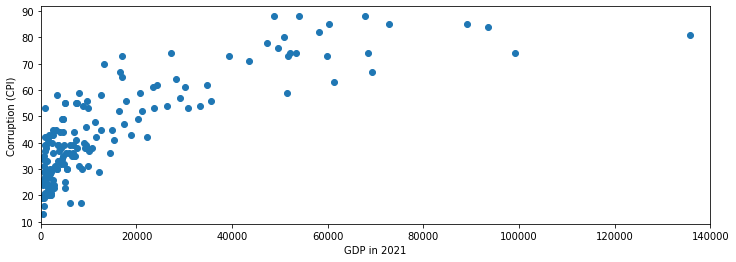

In [11]:
plot_cpi_against_gdp_for_year(joined_df, "2021", xmax=140000)

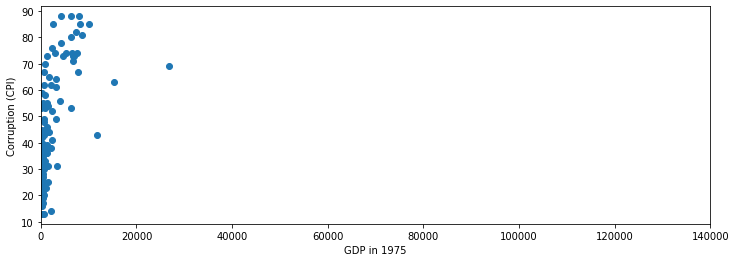

In [12]:
plot_cpi_against_gdp_for_year(joined_df, "1975", xmax=140000)

In [22]:
def get_bottom_countries_by_region(df, sort_column):
    bottom = []
    for region, grp in df.groupby("Region"):
        bottom.append(grp.sort_values(sort_column).head(1))
    df = pd.concat(bottom)
    return df


def get_top_countries_by_region(df, sort_column):
    bottom = []
    for region, grp in df.groupby("Region"):
        bottom.append(grp.sort_values(sort_column).tail(1))
    df = pd.concat(bottom)
    return df

In [24]:
def plot_cpi_against_change_in_gdp_per_capita(
    df, start_year, end_year, xmax=None, annotate_extremes=False
):
    def get_codes(year):
        return only_countries_with_gdp_in_year(df, year)[GDP_COUNTRY_CODE]

    start_year_codes = get_codes(start_year)
    end_year_codes = get_codes(end_year)
    common_codes = get_common_codes(start_year_codes, end_year_codes)

    mask = df[GDP_COUNTRY_CODE].apply(lambda code: code in common_codes)
    df_start_end = df[mask]
    change_in_gdp_per_capita = df_start_end[end_year] - df_start_end[start_year]
    year_range_column = f"{start_year}-{end_year}"
    df_start_end.loc[:, year_range_column] = change_in_gdp_per_capita

    fig, ax = plt.subplots(1, figsize=(10, 6))
    cmap = plt.get_cmap("tab20")
    markers = ["+", "D", "o", "s", ">", "X"]
    for i, (region, grp) in enumerate(df_start_end.groupby("Region")):
        ax.scatter(
            grp[year_range_column],
            grp[CORRUPTION_INDEX],
            label=region,
            color=cmap(i),
            marker=markers[i]
        )

    if annotate_extremes:
        def _annotate_extremes(df):
            for code, grp in df.groupby(GDP_COUNTRY_CODE):
                x = grp[year_range_column].values[0]
                y = grp[CORRUPTION_INDEX].values[0]
                ax.text(x + x*.01, y + y*.01, grp[GDP_COUNTRY_NAME].values[0])

        # Label countries with greatest or least growth in GDP per capita.
        df_top = get_top_countries_by_region(df_start_end, year_range_column)
        _annotate_extremes(df_top)
        df_least_corrupt = get_top_countries_by_region(df_start_end, CORRUPTION_INDEX)
        _annotate_extremes(df_least_corrupt)
            

    ax.set_xlabel(f"Change in GDP per capita from {start_year} to {end_year}")
    ax.set_ylabel("Corruption (CPI) in 2021")
    ax.legend(title="Region", loc='lower right')

    if xmax is not None:
        ax.set_xlim((0, xmax))

    fig.savefig(
        f"{NOTEBOOK_PATH}/change-in-gdp-per-capita-{start_year}-to-{end_year}.png",
        dpi=300
    )
    return df_start_end, year_range_column

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


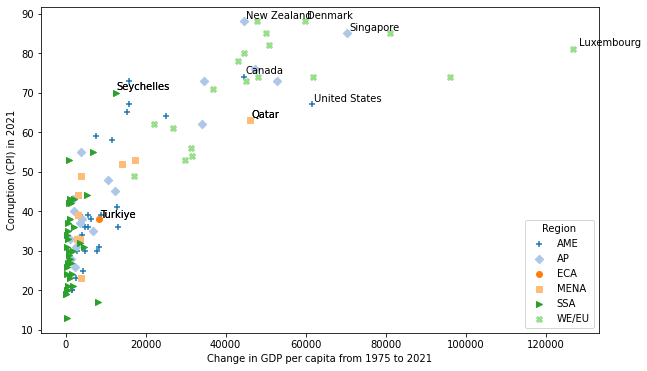

In [25]:
df_start_end, year_range_column = plot_cpi_against_change_in_gdp_per_capita(
    joined_df, "1975", "2021", annotate_extremes=True
)

In [33]:
columns = [GDP_COUNTRY_NAME, GDP_COUNTRY_CODE, CORRUPTION_INDEX, year_range_column, "Region"]
df_simple = df_start_end[columns]

In [34]:
df_richest = get_top_countries_by_region(df_simple, year_range_column)
df_richest

,Country Name,Country Code,CPI score 2021,1975-2021,Region
168,United States,USA,67,61486.079924,AME
140,Singapore,SGP,85,70304.091447,AP
163,Turkiye,TUR,38,8446.922425,ECA
133,Qatar,QAT,63,45983.424091,MENA
153,Seychelles,SYC,70,12500.492956,SSA
97,Luxembourg,LUX,81,126981.489543,WE/EU


In [35]:
df_least_corrupt = get_top_countries_by_region(df_simple, CORRUPTION_INDEX)
df_least_corrupt

,Country Name,Country Code,CPI score 2021,1975-2021,Region
25,Canada,CAN,74,44540.140122,AME
122,New Zealand,NZL,88,44629.915388,AP
163,Turkiye,TUR,38,8446.922425,ECA
133,Qatar,QAT,63,45983.424091,MENA
153,Seychelles,SYC,70,12500.492956,SSA
43,Denmark,DNK,88,59803.934438,WE/EU
